In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from mlxtend.frequent_patterns import apriori
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.frequent_patterns import association_rules

from google.colab import files as colab_files

In [ ]:
uploaded = colab_files.upload()

Saving food_drink_emoji_tweets.txt to food_drink_emoji_tweets.txt
Saving food_emoji_frequent_2_itemsets.csv to food_emoji_frequent_2_itemsets.csv


# **Part 1. Data Exploration**

In [ ]:
emoji_set = {'🍫', '🍡', '🍏', '🍈', '🍯', '🥠', '🍪', '🌰', '🥯', '🍐', '🌯', '🍧', '🥮', '🥚', '🍎', '🍍', '🍠',
'🍨', '🥣', '🍊', '🍘', '🍆', '🥓', '🌽', '🥐', '🌮', '🍬', '🍛', '🥘', '🥔', '🍿', '🍉', '🥞', '🍄', '🎂', '🧀', '🥩',
'🍺', '🦀', '🥦', '🥭', '🍒', '🍤', '🦐', '🥝', '🥙', '🍖', '🥜', '🍥', '🍷', '🍾', '🍲', '🧂', '🥪', '🍚', '🥬', '🥑',
'🍙', '🍞', '🥃', '🥗', '🍕', '🍔', '🥕', '🧁', '🍋', '🍰', '🥫', '🍗', '🥧', '🥛', '🍮', '🥡', '🍟', '🍅', '🥂', '🍸',
'🥥', '🍢', '🍌', '🍝', '🍵', '🍼', '🍦', '🍭', '🍑', '🍹', '🍇', '🥨', '🍱', '🦞', '☕', '🌶', '🍻', '🍳', '🥒', '🍣',
'🥟', '🥖', '🍶', '🍜', '🍓', '🦑', '🍩', '🌭'}

In [ ]:
def readFileLines(file):
  result = []
  with open(file, 'r') as file:
    while (True):
      raw_line = file.readline()
      if not raw_line: break
      result.append(raw_line.replace('\n', ''))
  return result

def outputFrame_with_column(arr, column=['']):
  return pd.DataFrame(arr, columns=column)

def extract_dataframe_emojis(post):
  temp_arr = [element for element in post if element in emoji_set]
  return np.unique(temp_arr)

In [ ]:
# data_emoji_df = pd.read_csv("food_drink_emoji_tweets.txt",sep='\n',header=None)
# data_emoji_df['emojis'] = data_emoji_df[0].apply(extract_dataframe_emojis)
# data_emoji_df.head(3)

**Part #a**

In [ ]:
data_emoji_arr = readFileLines('food_drink_emoji_tweets.txt')

In [ ]:
data_emoji_df = outputFrame_with_column(data_emoji_arr, column=['post_info'])

data_emoji_df.head(3)

,post_info
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...
1,RT @1_F_I_R_S_T: _ 🍈¹〉Grow your account fast! ...
2,RT @LegendDeols: 👉👉👉G€T Ready to dance💃🕺🕺🕺💃💃💃 ...


**Part #b**

In [ ]:
data_emoji_df['emojis'] = data_emoji_df['post_info'].apply(extract_dataframe_emojis)
data_emoji_df.head(3)

,post_info,emojis
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...,"[🌯, 🍒, 🍔, 🍗]"
1,RT @1_F_I_R_S_T: _ 🍈¹〉Grow your account fast! ...,"[🍇, 🍈, 🍉, 🍊, 🍍, 🍓]"
2,RT @LegendDeols: 👉👉👉G€T Ready to dance💃🕺🕺🕺💃💃💃 ...,"[🍸, 🥃]"


**Part #c**

In [ ]:
mlb_classifier = MultiLabelBinarizer()
emoji_matrix = mlb_classifier.fit_transform(data_emoji_df['emojis'])

In [ ]:
mlb_classifier = pd.DataFrame(emoji_matrix, columns=mlb_classifier.classes_)
mlb_classifier.head(3)

,☕,🌭,🌮,🌯,🌰,🌶,🌽,🍄,🍅,🍆,...,🥭,🥮,🥯,🦀,🦐,🦑,🦞,🧀,🧁,🧂
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1.2 Exploratory Data Analysis (EDA)

In [ ]:
emojis_total_num = 0
tempArr = []
for (colName, colData) in data_emoji_df.iteritems():
  if(colName == 'emojis'):
    for row in colData:
      for ele in row:
        if ele not in tempArr:
          tempArr.append(ele)

emojis_total_num = len(tempArr)
print(emojis_total_num, ' different emojis are used in the dataset.')

105  different emojis are used in the dataset.


In [ ]:
sum1= mlb_classifier.sum(axis=1)
meanVal = sum1.mean()
print('The average number of the deployed emojis is ', meanVal)

The average number of the deployed emojis is  2.6302


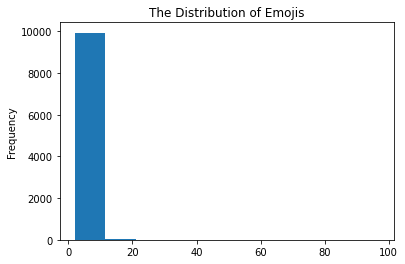

In [ ]:
emojis_total_num.plot(kind='hist', title='The Distribution of Emojis')

In [ ]:
mlb_classifier.sum(axis=0).sort_values(ascending=False)[:5]

🍻    1819
🎂    1486
🍔    1384
🍾    1082
🥂    1031
dtype: int64

# **Part 2. The Apriori Algorithm**

**Part #a.**

In [ ]:
def emoji_frequent_itemsets(df, k, min_support):
  frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
  frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda item: len(item))
  smaller_scope = frequent_itemsets[frequent_itemsets['length'] == k]
  return smaller_scope[['support', 'itemsets']]

**Part #b.**

In [ ]:
frequent_itemsets_3 = emoji_frequent_itemsets(mlb_classifier, 3, 0.007)
frequent_itemsets_3.head(3)

,support,itemsets
155,0.0079,"(🍊, 🍇, 🍉)"
156,0.0092,"(🍔, 🍟, 🍕)"
157,0.0070,"(🍭, 🍬, 🍫)"


**2.1 Apriori Algorithm under the Hood**

**2.1.1 Candidate Generation**

**Part #a.**

In [ ]:
def generate_candidate_3_itemsets(arr):
  result = set()
  for ele1 in arr:
    for ele2 in arr:
      tempSet = ele1.union(ele2)
      if(len(tempSet) == 3): result.add(frozenset(tempSet))

  return list(result)

In [ ]:
# load the 'food_emoji_frequent_2_itemsets.csv'
frequent2_itemsets_df = pd.read_csv('food_emoji_frequent_2_itemsets.csv', names=['itemset'])
frequent2_itemsets_df.head(3)

,itemset
0,🌭🍔
1,🌭🍕
2,🍔🌮


In [ ]:
def extract_freq2_itemsets(post):
  temp_arr = [element for element in post if element in emoji_set]
  return set(np.unique(temp_arr))

frequent2_itemsets_df['itemset'] = frequent2_itemsets_df['itemset'].apply(extract_freq2_itemsets)
frequent2_itemsets_df.head(3)

,itemset
0,"{🍔, 🌭}"
1,"{🍕, 🌭}"
2,"{🍔, 🌮}"


In [ ]:
frequent3_itemsets_arr = generate_candidate_3_itemsets(frequent2_itemsets_df['itemset'].tolist())
frequent3_itemsets_arr[:3]
print(len(frequent3_itemsets_arr))

286


**Part #b.**

In [ ]:
def update_candidate_3_itemsets(arr3, arr2):
    freq_3_itemsets = set()

    for ele1 in arr3:
        subsets = [set(i) for i in combinations(ele1, 2)]
        if all(ele2 in arr2 for ele2 in subsets):
            freq_3_itemsets.add(frozenset(ele1))
    return list(freq_3_itemsets)

In [ ]:
updated_3_itemsets = update_candidate_3_itemsets(frequent3_itemsets_arr, frequent2_itemsets_df['itemset'].tolist())

**2.1.2 Database Scan**

**Part #a.**

In [ ]:
updated_3_itemsets_len = len(updated_3_itemsets)
def calculate_frequent_itemsets(candidate_itemsets, min_support):
    df = pd.DataFrame({'itemset': updated_3_itemsets, 'support': [0.0] * updated_3_itemsets_len})

    for idx1, row in mlb_classifier.iterrows():
        for idx2, candidate in df.iterrows():
            ele1, ele2, ele3 = candidate['itemset']
            if (row[ele1] and row[ele2] and row[ele3]): df['support'][idx2] += 1
    df['support'] /= len(mlb_classifier)
    
    result = df[df['support'] >= min_support]['itemset'].tolist()
    return result

calculate_frequent_itemsets(updated_3_itemsets, 0.005)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[frozenset({'🍇', '🍉', '🍊'}),
 frozenset({'🍇', '🍊', '🥝'}),
 frozenset({'🍉', '🍊', '🥝'}),
 frozenset({'🍦', '🍧', '🍨'}),
 frozenset({'🍇', '🍉', '🍍'}),
 frozenset({'🍇', '🍍', '🥝'}),
 frozenset({'🍉', '🍍', '🥝'}),
 frozenset({'🍫', '🍰', '🎂'}),
 frozenset({'🍔', '🍕', '🍟'}),
 frozenset({'🍇', '🍉', '🥝'}),
 frozenset({'🍉', '🍊', '🍍'}),
 frozenset({'🍊', '🍍', '🥝'}),
 frozenset({'🍇', '🍊', '🍍'}),
 frozenset({'🍫', '🍬', '🍭'})]

# **Part 3. Evaluating Frequent Itemsets**

**Part #a.**

In [ ]:
frequent_itemsets = apriori(mlb_classifier, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(☕),(🍩),0.0589,0.0312,0.0084,0.142615,4.570981,0.006562,1.129947
1,(🍩),(☕),0.0312,0.0589,0.0084,0.269231,4.570981,0.006562,1.287821
2,(🍔),(🌭),0.1384,0.0193,0.0113,0.081647,4.230435,0.008629,1.067890
3,(🌭),(🍔),0.0193,0.1384,0.0113,0.585492,4.230435,0.008629,2.078610
4,(🌭),(🍕),0.0193,0.0441,0.0050,0.259067,5.874543,0.004149,1.290131
...,...,...,...,...,...,...,...,...,...
507,"(🍺, 🍻)","(🍸, 🍹)",0.0427,0.0232,0.0051,0.119438,5.148187,0.004109,1.109291
508,(🍸),"(🍹, 🍺, 🍻)",0.0518,0.0065,0.0051,0.098456,15.147015,0.004763,1.101998
509,(🍹),"(🍸, 🍺, 🍻)",0.0615,0.0069,0.0051,0.082927,12.018381,0.004676,1.082902
510,(🍺),"(🍸, 🍹, 🍻)",0.0799,0.0075,0.0051,0.063830,8.510638,0.004501,1.060170


**Part #b.**

In [ ]:
def mi(antecedent_support, consequent_support, support):
  leftTrue = antecedent_support
  rightTrue = consequent_support
  leftFalse = 1 - leftTrue
  rightFalse = 1 - rightTrue

  bothTrue = support
  leftTrue_rightFalse = antecedent_support - support
  leftFalse_rightTrue = consequent_support - support
  bothFalse = 1 - bothTrue - leftTrue_rightFalse - leftFalse_rightTrue

  result = bothTrue * math.log2(bothTrue / (leftTrue * rightTrue)) + leftFalse_rightTrue * math.log2(leftFalse_rightTrue / (leftFalse * rightTrue)) + leftTrue_rightFalse * math.log2(leftTrue_rightFalse / (leftTrue * rightFalse)) + bothFalse * math.log2(bothFalse / (leftFalse * rightFalse))
  
  return result

**Part #c.**

In [ ]:
mutualInfo = []
for idx, row in rules.iterrows():
  mutualResult = mi(row['antecedent support'], row['consequent support'], row['support'])
  mutualInfo.append(mutualResult)
rules['mutualInfo'] = mutualInfo
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutualInfo
0,(☕),(🍩),0.0589,0.0312,0.0084,0.142615,4.570981,0.006562,1.129947,0.010697
1,(🍩),(☕),0.0312,0.0589,0.0084,0.269231,4.570981,0.006562,1.287821,0.010697
2,(🍔),(🌭),0.1384,0.0193,0.0113,0.081647,4.230435,0.008629,1.067890,0.015536
3,(🌭),(🍔),0.0193,0.1384,0.0113,0.585492,4.230435,0.008629,2.078610,0.015536
4,(🌭),(🍕),0.0193,0.0441,0.0050,0.259067,5.874543,0.004149,1.290131,0.007827
...,...,...,...,...,...,...,...,...,...,...
507,"(🍺, 🍻)","(🍸, 🍹)",0.0427,0.0232,0.0051,0.119438,5.148187,0.004109,1.109291,0.007029
508,(🍸),"(🍹, 🍺, 🍻)",0.0518,0.0065,0.0051,0.098456,15.147015,0.004763,1.101998,0.017349
509,(🍹),"(🍸, 🍺, 🍻)",0.0615,0.0069,0.0051,0.082927,12.018381,0.004676,1.082902,0.015252
510,(🍺),"(🍸, 🍹, 🍻)",0.0799,0.0075,0.0051,0.063830,8.510638,0.004501,1.060170,0.012302


# **Part 4. Itemset Similarity**

**Part #a.**

In [ ]:
from numpy.lib.arraysetops import intersect1d
def list_intersection(A, B):
  result = []
  for A_ele in A:
    for B_ele in B:
      if A_ele == B_ele:
        result.append(A_ele)
  return result

def list_union(A, B):
  result = []
  for A_ele in A:
    result.append(A_ele)
  for B_ele in B:
    if B_ele not in result:
      result.append(B_ele)
  return result

def jaccard_similtarity(A, B):
  intersection = list_intersection(A, B)
  union = list_union(A, B)
  return 0 if (len(intersection) == 0) else len(intersection)/len(union)

**Part #b.**

In [ ]:
compare_df = data_emoji_df.copy()
compare_df['similarity'] = 0.000
data_emoji_df.head(3)

,post_info,emojis
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...,"[🌯, 🍒, 🍔, 🍗]"
1,RT @1_F_I_R_S_T: _ 🍈¹〉Grow your account fast! ...,"[🍇, 🍈, 🍉, 🍊, 🍍, 🍓]"
2,RT @LegendDeols: 👉👉👉G€T Ready to dance💃🕺🕺🕺💃💃💃 ...,"[🍸, 🥃]"


In [ ]:
compare_samples1 = data_emoji_df.loc[0]['emojis']
for (idx, row) in compare_df.iterrows():
  compare_samples2 = row['emojis']
  compare_df['similarity'][idx] = jaccard_similtarity(compare_samples1, compare_samples2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
compare_df.sort_values(by=['similarity'], ascending=False).head(10)

,post_info,emojis,similarity
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...,"[🌯, 🍒, 🍔, 🍗]",1.00
6800,RT @levelscafeabuja: Chow! 🤩💦🍗🌯🍔 #LevelsCafeAb...,"[🌯, 🍔, 🍗]",0.75
5334,RT @thatssochioma: You don’t want to miss this...,"[🍔, 🍗]",0.50
3466,@jewishmuseummd @americanart I'm definitely in...,"[🍒, 🍗]",0.50
7877,@tafarireid07 Did you say bbq? 🔥🍔🍗🚙,"[🍔, 🍗]",0.50
7692,RT @WVUfootball: We have some new digs! 🍴🍗🍔 #H...,"[🍔, 🍗]",0.50
777,@SunnyAnderson @rosannascotto I don’t think KF...,"[🍔, 🍗]",0.50
7428,Kicking off the weekend with a cheeky BBQ? Her...,"[🍔, 🍗]",0.50
1958,@jenkirk72 @baseball_kay How was the race? Als...,"[🌯, 🍔]",0.50
9861,Reminder that our friends in @SouthsideSNP are...,"[🍔, 🍗]",0.50
